In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk

In [2]:
df = pd.read_csv('Reviews_sentiment_clean.csv')

In [3]:
df.drop(['Unnamed: 0'], axis=1,inplace=True)

In [4]:
df

,comments,sentiment
0,Magda has a great place and she is so so very ...,1
1,very new and clean place! about 30min from Her...,1
2,Nicle Appartement close to many shops and coff...,1
3,Very nice stay! Good communication with the ho...,1
4,Magda is a very nice and friendly host. She re...,1
...,...,...
190134,Mira Living Concept was the perfect place to s...,1
190135,"Very nice new apartments - great design, comfo...",2
190136,Antonis place is amazing! The rooms are beauti...,1
190137,Perfect stay with very nice and warm welcome. ...,2


In [5]:
df.groupby('sentiment').count().reset_index()

,sentiment,comments
0,0,234
1,1,166083
2,2,23822


There seems to be quite the imbalanced dataset

In [7]:
df = df[df.sentiment != 1]

In [8]:
import re
df.sentiment[df.sentiment == 2] = 1 
df['comments'] = df['comments'].apply(lambda x: x.lower())
# removing special chars
df['comments'] = df['comments'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
df['comments'] = df['comments'].str.replace('rt','')
df['comments']

<ipython-input-8-8b0e9cc09198>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sentiment[df.sentiment == 2] = 1
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-8-8b0e9cc09198>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comments'] = df['comments']

9                                  we had a great time here
56        very nice house with beautiful view very nice ...
71        the hosts here are simply perfect they are so ...
85        amazing host amazing home made breakfast amazi...
119           a great place right in the middle of paradise
                                ...                        
190126    really nice apament and lovely hosts and they ...
190128    very nice and warm welcome in this beautiful b...
190129    antonis was the perfect host the apaments were...
190135    very nice new apaments  great design comfoable...
190137    perfect stay with very nice and warm welcome t...
Name: comments, Length: 24056, dtype: object

In [9]:
df

,comments,sentiment
9,we had a great time here,1
56,very nice house with beautiful view very nice ...,1
71,the hosts here are simply perfect they are so ...,1
85,amazing host amazing home made breakfast amazi...,1
119,a great place right in the middle of paradise,1
...,...,...
190126,really nice apament and lovely hosts and they ...,1
190128,very nice and warm welcome in this beautiful b...,1
190129,antonis was the perfect host the apaments were...,1
190135,very nice new apaments great design comfoable...,1


In [10]:
from sklearn.utils import shuffle
# Separate majority and minority classes
data_majority = df[df['sentiment'] == 1]
data_minority = df[df['sentiment'] == 0]

bias = data_minority.shape[0]/data_majority.shape[0]
# lets split train/test data first then 
train = pd.concat([data_majority.sample(frac=0.8,random_state=200),
         data_minority.sample(frac=0.8,random_state=200)])
test = pd.concat([data_majority.drop(data_majority.sample(frac=0.8,random_state=200).index),
        data_minority.drop(data_minority.sample(frac=0.8,random_state=200).index)])

train = shuffle(train)
test = shuffle(test)

In [11]:
print('positive data in training:',(train.sentiment == 1).sum())
print('negative data in training:',(train.sentiment == 0).sum())
print('positive data in test:',(test.sentiment == 1).sum())
print('negative data in test:',(test.sentiment == 0).sum())

positive data in training: 19058
negative data in training: 187
positive data in test: 4764
negative data in test: 47


In [12]:
from sklearn.utils import resample
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# Separate majority and minority classes in training data for upsampling 
data_majority = train[train['sentiment'] == 1]
data_minority = train[train['sentiment'] == 0]

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled])
 
# Display new class counts
print("After upsampling\n",data_upsampled.sentiment.value_counts(),sep = "")

max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['comments'].values) # training with whole data

X_train = tokenizer.texts_to_sequences(data_upsampled['comments'].values)
X_train = pad_sequences(X_train,maxlen=29)
Y_train = pd.get_dummies(data_upsampled['sentiment']).values
print('x_train shape:',X_train.shape)

X_test = tokenizer.texts_to_sequences(test['comments'].values)
X_test = pad_sequences(X_test,maxlen=29)
Y_test = pd.get_dummies(test['sentiment']).values
print("x_test shape", X_test.shape)

majority class before upsample: (19058, 2)
minority class before upsample: (187, 2)
After upsampling
0    19058
1    19058
Name: sentiment, dtype: int64
x_train shape: (38116, 29)
x_test shape (4811, 29)


In [32]:
words = pd.DataFrame(data=list(tokenizer.word_counts.items())[:2000],columns=['word','count'])
words = words.sort_values(by='count',ascending=False).reset_index(drop=True)

# in order to find most commonly used words, descriptive of crete 
# we manually remove any rows that dont offer information about the island 
words.drop([0,2,3,4,6,9,10,13,14,15,18,24,29,30,32,35,37,38,39,40,44,45,46,50,53,54,57,58,59,63,64,67,69,70,72,80,81,83,84,86,87,89,91,93,95,96,10,102,108,110,113,114,118,126,128,132,133,134,150,152,167,179,183,188,190,192,194,202,210,214,215,227,269,273,274,309,336,351,365,391,398,403,409,423,428,458,459,464,465,469,471,481,483,485,487,494,496], axis=0, inplace=True)
words.reset_index(drop=True,inplace=True)
#words.to_csv('words.csv')

In [39]:
# 50 most common words , we assume those are the things people care about.
words[:50]

,word,count
0,great,13274
1,place,7678
2,nice,6963
3,location,6910
4,host,5558
5,clean,5483
6,perfect,4501
7,stay,4355
8,beautiful,3859
9,apament,3797


In [40]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

# model
embed_dim = 128
lstm_out = 192

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 29, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 29, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 192)               246528    
                                                                 
 dense (Dense)               (None, 2)                 386       
                                                                 
Total params: 502,914
Trainable params: 502,914
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
batch_size = 128
# also adding weights
class_weights = {0: 1 ,
                1: 1.6/bias }
model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 1,
          class_weight=class_weights)

Epoch 1/15
298/298 [==============================] - 44s 133ms/step - loss: 2.0687 - accuracy: 0.8429
Epoch 2/15
298/298 [==============================] - 60s 200ms/step - loss: 0.2493 - accuracy: 0.9518
Epoch 3/15
298/298 [==============================] - 65s 219ms/step - loss: 0.0909 - accuracy: 0.9851
Epoch 4/15
298/298 [==============================] - 66s 223ms/step - loss: 0.0738 - accuracy: 0.9888
Epoch 5/15
298/298 [==============================] - 65s 219ms/step - loss: 0.0253 - accuracy: 0.9950
Epoch 6/15
298/298 [==============================] - 69s 231ms/step - loss: 0.0337 - accuracy: 0.9942
Epoch 7/15
298/298 [==============================] - 66s 220ms/step - loss: 0.0754 - accuracy: 0.9912
Epoch 8/15
298/298 [==============================] - 66s 220ms/step - loss: 0.0087 - accuracy: 0.9987
Epoch 9/15
298/298 [==============================] - 61s 205ms/step - loss: 0.0208 - accuracy: 0.9964
Epoch 10/15
298/298 [==============================] - 52s 176ms/step - l

In [42]:
scores = model.evaluate(X_test, Y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy that I passed in metrics=['accuracy']

Test accuracy: 0.9968821406364441


In [43]:
Y_pred = model.predict(X_test,batch_size = batch_size)

38/38 [==============================] - 1s 25ms/step


[1 1 1 ... 1 1 1]


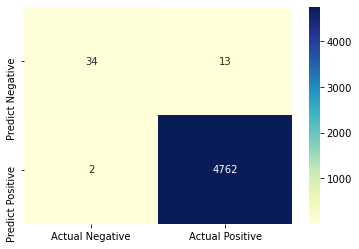

In [61]:
from sklearn.metrics import confusion_matrix,classification_report
from keras.utils.np_utils import to_categorical
import numpy as np
import seaborn as sns

y_pred=np.argmax(Y_pred, axis=1)
y_test=np.argmax(Y_test, axis=1)
print(y_pred)
cm = confusion_matrix(y_test, y_pred)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()


In [49]:

print("confusion matrix",confusion_matrix(y_pred, y_test))
print(classification_report(y_test, y_pred))

confusion matrix [[  34    2]
 [  13 4762]]
              precision    recall  f1-score   support

           0       0.94      0.72      0.82        47
           1       1.00      1.00      1.00      4764

    accuracy                           1.00      4811
   macro avg       0.97      0.86      0.91      4811
weighted avg       1.00      1.00      1.00      4811



In [74]:
twt = ['the worst']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=29, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3 450]]
1/1 - 0s - 23ms/epoch - 23ms/step
negative


In [54]:
X_cs = tokenizer.texts_to_sequences(words['word'].values)
X_cs = pad_sequences(X_cs, maxlen=29, dtype='int32', value=0)

In [68]:
sentiment = model.predict(X_cs,batch_size = batch_size)

15/15 [==============================] - 0s 25ms/step


In [69]:
sentiment=np.argmax(sentiment, axis=1)
sentiment

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [70]:
words['sentiment'] = sentiment.tolist()
words['sentiment'] = words['sentiment'].replace([1,0],['positive','negative'])
#words.to_csv('interest_sentiment.csv')

In [79]:
words[words['sentiment'] == 'negative']

,word,count,sentiment
160,bad,172,negative
321,nothing,74,negative
361,worst,64,negative
553,look,33,negative
723,review,21,negative
786,per,17,negative
930,app,12,negative
1162,concerns,6,negative


amongst the 2000 most used words our Neural Network determines that only the above ones produce negative feelings to airbnb costumers in crete. This kind of makes sense since the vast majority of reviews were posistive. My last remark is that amongst the negative reviews, there were common mentions of bugs and smells, words that arent classified as negative by the classifier. This may be due to misclassification or maybe there are as many positive reviews that somewhow include these words.